# **EXPERIMENT-2** : **RNN + FastText and Bi-LSTM + FastText**

### **Objective: Compare RNN and Bi-LSTM models trained using FastText embeddings and evaluate performance differences.** 

In [ ]:
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.13.1 datasets gensim

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached pyarrow-20.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  U

In [ ]:
!pip install datasets #for loading PLOD-CW-25
!pip install gensim #for loading FastText embeddings

In [ ]:
from datasets import load_dataset

# Loading the PLOD-CW-25 dataset from Hugging Face
dataset = load_dataset("surrey-nlp/PLOD-CW-25")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/268 [00:00<?, ?B/s]

PLOD-CW-25-Train.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

PLOD-CW-25-Test.parquet:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

PLOD-CW-25-Val.parquet:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/150 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 150
    })
})


In [ ]:
import random
import numpy as np
import torch

def set_seed(seed: int, verbose: bool = False) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

    # Ensure deterministic behavior (at the cost of performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    if verbose:
        print(f"[INFO] Seed set to {seed} (deterministic: True, benchmark: False)")

# Usage
set_seed(24, verbose=True)

[INFO] Seed set to 24 (deterministic: True, benchmark: False)


# A. Preprocessing Tokens, Labels and POS Tags

### 1. Token Preparation

In [ ]:
# Extracting tokens and converting to lowercase properly
tokens_train = [[token.lower() for token in ex['tokens']] for ex in dataset['train']]
tokens_val   = [[token.lower() for token in ex['tokens']] for ex in dataset['validation']]
tokens_test  = [[token.lower() for token in ex['tokens']] for ex in dataset['test']]

### 2. NER Label Encoding

In [ ]:
# Collecting all unique NER tags from the training set
unique_ner_tags = set(tag for ex in dataset['train'] for tag in ex['ner_tags'])
ner2id = {tag: idx for idx, tag in enumerate(sorted(unique_ner_tags))}

ner_tag_list = sorted(list(unique_ner_tags))
print("Unique NER tags:", ner_tag_list)

Unique NER tags: ['B-AC', 'B-LF', 'I-LF', 'O']


In [ ]:
def encode_ner_tags(example):
    example['ner_ids'] = [ner2id[tag] for tag in example['ner_tags']]
    return example

In [ ]:
encoded_dataset = dataset.map(encode_ner_tags, batched=False)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
print(encoded_dataset['train'].column_names)
print(encoded_dataset['validation'].column_names)
print(encoded_dataset['test'].column_names)

['tokens', 'pos_tags', 'ner_tags', 'ner_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids']


In [ ]:
# Checking a sample to confirm
for i in range(3):
    print(f"\nExample {i+1}")
    print("Tokens:     ", encoded_dataset['train'][i]['tokens'])
    print("NER tags:   ", encoded_dataset['train'][i]['ner_tags'])
    print("NER IDs:    ", encoded_dataset['train'][i]['ner_ids'])



Example 1
Tokens:      ['MRR', ',', 'mortality', 'rate', 'ratio', ';', 'TBI', ',', 'traumatic', 'brain', 'injury', '.']
NER tags:    ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']
NER IDs:     [0, 3, 1, 2, 2, 3, 0, 3, 1, 2, 2, 3]

Example 2
Tokens:      ['HPC', ',', 'hippocampus', ';', 'mOFC', ',', 'medial', 'OFC', ';', 'OFC', ',', 'orbitofrontal', 'cortex', ';', 'PPI', ',', 'psychophysiological', 'interaction', '.']
NER tags:    ['B-AC', 'O', 'B-LF', 'O', 'O', 'O', 'O', 'B-AC', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'O']
NER IDs:     [0, 3, 1, 3, 3, 3, 3, 0, 3, 0, 3, 1, 2, 3, 0, 3, 1, 2, 3]

Example 3
Tokens:      ['In', 'addition', 'to', 'the', 'effects', 'on', 'cell', 'growth', 'and', 'migration', ',', 'the', '18β', '-', 'GA', '-', 'd', 'used', 'in', 'this', 'study', 'could', 'also', 'up', '-', 'regulate', 'expression', 'of', 'aquaporin-3', '(', 'AQP-3', ')', 'in', 'fibroblasts', 'and', 'keratinocytes', '.']
NER tag

In [ ]:
# extract for inspection
ner_train = [sentence['ner_tags'] for sentence in dataset['train']]
ner_val   = [sentence['ner_tags'] for sentence in dataset['validation']]
ner_test  = [sentence['ner_tags'] for sentence in dataset['test']]

In [ ]:
print(encoded_dataset['train'].column_names)
print(encoded_dataset['validation'].column_names)
print(encoded_dataset['test'].column_names)

['tokens', 'pos_tags', 'ner_tags', 'ner_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids']


### 3. POS Tag Assignment

In [ ]:
# Extracting POS tags
unique_pos_tags = set()
for example in dataset['train']:
    unique_pos_tags.update(example['pos_tags'])

pos_tag_list = sorted(list(unique_pos_tags))
print(" Unique POS tags:")
print(pos_tag_list)
print(f"Total POS tag types: {len(pos_tag_list)}")


 Unique POS tags:
['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']
Total POS tag types: 17


In [ ]:
# Creating mappings
pos2id = {pos: idx for idx, pos in enumerate(pos_tag_list)}
id2pos = {idx: pos for pos, idx in pos2id.items()}

# Printing sample of the mapping
print("\nPOS to ID mapping (sample):")
for i, (k, v) in enumerate(pos2id.items()):
    print(f"{k}: {v}")
    if i == 10: break  # just show first 10



POS to ID mapping (sample):
ADJ: 0
ADP: 1
ADV: 2
AUX: 3
CCONJ: 4
DET: 5
INTJ: 6
NOUN: 7
NUM: 8
PART: 9
PRON: 10


In [ ]:
print(encoded_dataset['train'].column_names)
print(encoded_dataset['validation'].column_names)
print(encoded_dataset['test'].column_names)

['tokens', 'pos_tags', 'ner_tags', 'ner_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids']


In [ ]:
# Encoding POS tags in each example
def encode_pos_tags(example):
    example['pos_ids'] = [pos2id[pos] for pos in example['pos_tags']]
    return example

# First encode NER tags
encoded_dataset = dataset.map(encode_ner_tags)
encoded_dataset = encoded_dataset.map(encode_pos_tags)

print("\n Sample POS tags and encoded IDs:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print("POS Tags:", encoded_dataset['train'][i]['pos_tags'])
    print("POS IDs: ", encoded_dataset['train'][i]['pos_ids'])


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]


 Sample POS tags and encoded IDs:

Example 1:
POS Tags: ['NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']
POS IDs:  [7, 12, 7, 7, 7, 12, 11, 12, 0, 7, 7, 12]

Example 2:
POS Tags: ['PROPN', 'PUNCT', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'ADJ', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'ADJ', 'NOUN', 'PUNCT']
POS IDs:  [11, 12, 7, 12, 7, 12, 0, 11, 12, 11, 12, 0, 7, 12, 7, 12, 0, 7, 12]

Example 3:
POS Tags: ['ADP', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'CCONJ', 'NOUN', 'PUNCT', 'DET', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'NOUN', 'VERB', 'ADP', 'DET', 'NOUN', 'AUX', 'ADV', 'ADV', 'PUNCT', 'VERB', 'NOUN', 'ADP', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'ADP', 'NOUN', 'CCONJ', 'NOUN', 'PUNCT']
POS IDs:  [1, 7, 1, 5, 7, 1, 7, 7, 4, 7, 12, 5, 7, 12, 7, 12, 7, 15, 1, 5, 7, 3, 2, 2, 12, 15, 7, 1, 7, 12, 7, 12, 1, 7, 4, 7, 12]


In [ ]:
print(encoded_dataset['train'].column_names)
print(encoded_dataset['validation'].column_names)
print(encoded_dataset['test'].column_names)

['tokens', 'pos_tags', 'ner_tags', 'ner_ids', 'pos_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids', 'pos_ids']
['tokens', 'pos_tags', 'ner_tags', 'ner_ids', 'pos_ids']


### 4. Checking alignment

In [ ]:
for split in ['train', 'validation', 'test']:
    for example in encoded_dataset[split]:
        assert len(example['tokens']) == len(example['pos_ids']) == len(example['ner_ids']), \
            f"Alignment issue in {split} split! Example: {example}"
print(" All sequences (tokens, POS tags, NER tags) are correctly aligned.")


 All sequences (tokens, POS tags, NER tags) are correctly aligned.


In [ ]:
# First three examples
for i in range(3):
    ex = encoded_dataset['train'][i]
    print(f"\n Example {i+1}")
    print("Tokens:   ", ex['tokens'])
    print("POS Tags: ", ex['pos_tags'])
    print("POS IDs:  ", ex['pos_ids'])
    print("NER Tags: ", ex['ner_tags'])
    print("NER IDs:  ", ex['ner_ids'])



 Example 1
Tokens:    ['MRR', ',', 'mortality', 'rate', 'ratio', ';', 'TBI', ',', 'traumatic', 'brain', 'injury', '.']
POS Tags:  ['NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT']
POS IDs:   [7, 12, 7, 7, 7, 12, 11, 12, 0, 7, 7, 12]
NER Tags:  ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']
NER IDs:   [0, 3, 1, 2, 2, 3, 0, 3, 1, 2, 2, 3]

 Example 2
Tokens:    ['HPC', ',', 'hippocampus', ';', 'mOFC', ',', 'medial', 'OFC', ';', 'OFC', ',', 'orbitofrontal', 'cortex', ';', 'PPI', ',', 'psychophysiological', 'interaction', '.']
POS Tags:  ['PROPN', 'PUNCT', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'ADJ', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT', 'ADJ', 'NOUN', 'PUNCT']
POS IDs:   [11, 12, 7, 12, 7, 12, 0, 11, 12, 11, 12, 0, 7, 12, 7, 12, 0, 7, 12]
NER Tags:  ['B-AC', 'O', 'B-LF', 'O', 'O', 'O', 'O', 'B-AC', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 

In [ ]:
# extracting for inspection:
pos_train = [ex['pos_tags'] for ex in encoded_dataset['train']]
pos_val   = [ex['pos_tags'] for ex in encoded_dataset['validation']]
pos_test  = [ex['pos_tags'] for ex in encoded_dataset['test']]

### 5. Padding tokens, ner_tags, and pos_tags

In [ ]:
# Getting max length of any sequence in training set
max_len = max(len(ex['tokens']) for ex in encoded_dataset['train'])
print(f" Max sequence length in training set: {max_len}")


 Max sequence length in training set: 371


In [ ]:
def pad_sequence(seq, max_len, pad_value):
    return seq + [pad_value] * (max_len - len(seq))

In [ ]:
def pad_example(example):
    example['pos_ids_padded'] = pad_sequence(example['pos_ids'], max_len, pad_value=0)
    example['ner_ids_padded'] = pad_sequence(example['ner_ids'], max_len, pad_value=-100)  # -100 is often used for ignored loss positions
    return example

padded_dataset = encoded_dataset.map(pad_example)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
for i in range(2):
    ex = padded_dataset['train'][i]
    print(f"\n Example {i+1}")
    print("POS IDs (padded):", ex['pos_ids_padded'])
    print("NER IDs (padded):", ex['ner_ids_padded'])
    print("Original length:", len(ex['pos_ids']), "| Padded length:", len(ex['pos_ids_padded']))



 Example 1
POS IDs (padded): [7, 12, 7, 7, 7, 12, 11, 12, 0, 7, 7, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

# B. Word Embedding using FastText (Facebook Pre-trained Model)

## Download and load FastText Embeddings

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gunzip cc.en.300.bin.gz

--2025-05-11 02:29:55--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.68, 3.171.22.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   199MB/s    in 19s     

2025-05-11 02:30:14 (223 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313501 sha256=c362e4131846a6234ea888c21cfc020f6710cfa65d2110529dbdaae1093374a0
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
import fasttext
fasttext_model = fasttext.load_model('cc.en.300.bin')

print(fasttext_model.get_dimension())
print(fasttext_model.get_words()[:10])  # Prints the first 10 words in the vocabulary

300
[',', 'the', '.', 'and', 'to', 'of', 'a', '</s>', 'in', 'is']


In [ ]:
# Get embedding vector for a word
vector = fasttext_model.get_word_vector('biology')
print(vector.shape)

(300,)


In [ ]:
# Check nearest neighbors
neighbors = fasttext_model.get_nearest_neighbors('biology', k=5)
for score, word in neighbors:
    print(f"{word}: {score:.4f}")

biochemistry: 0.7436
Biology: 0.7135
physiology: 0.7066
biology-: 0.6991
biology.The: 0.6988


#### 1. Out-Of-Vocabulary (OOV) Tokens Coverage Analysis

In [ ]:
# Extracting all tokens from train, validation, and test splits
token_lists = [ex['tokens'] for split in ['train'] for ex in padded_dataset[split]]

# Flatten token lists and build a unique vocabulary set
vocab = set(token for sent in token_lists for token in sent)

print(f"Vocab size: {len(vocab)}")

Vocab size: 14740


In [ ]:
# List of OOV tokens
oov_tokens = [token for token in vocab if token not in fasttext_model]

print(f" Number of OOV tokens: {len(oov_tokens)}")
print("Sample OOV tokens:", oov_tokens[:20])

 Number of OOV tokens: 1802
Sample OOV tokens: ['-refer', 'ISOpull', 'OSCN-', 'RR241', 'NIDCM', 'GPAT2', 'rabbitpox', '4′,6', 'M+E', 'Intravoxel', 'SI0', '13],[14', 'VERNALIZATION', '11–25', 'LAA%', 'p<0.05', 'QALE', '55–61', 'ITV]-DSPP', 'CVVHD']


In [ ]:
#Checking if FastText Can Still Embed OOV Tokens
can_embed = 0
for token in oov_tokens:
    try:
        _ = fasttext_model[token]
        can_embed += 1
    except KeyError:
        pass

print(f"FastText can generate embeddings for {can_embed} / {len(oov_tokens)} OOV tokens")

FastText can generate embeddings for 1802 / 1802 OOV tokens


The coverage analysis of the dataset vocabulary against the FastText model revealed a total of 1,802 out-of-vocabulary (OOV) tokens — words that were not directly present in the FastText vocabulary list. However, FastText was still able to successfully generate embeddings for all 1,802 of these OOV tokens through its subword n-gram approach. This confirms FastText’s capability to handle rare and unseen words effectively, ensuring comprehensive token embedding coverage even for tokens outside its original training vocabulary.

#### 2. Word Similarity and Analogy Tasks.



In [ ]:
words_to_check = ['protein', 'cell', 'gene', 'enzyme']

for word in words_to_check:
    print(f"\n Similar words to '{word}':")
    neighbors = fasttext_model.get_nearest_neighbors(word, k=5)
    for score, neighbor in neighbors:
        print(f"{neighbor:20} Similarity Score: {score:.4f}")



 Similar words to 'protein':
proteins             Similarity Score: 0.8211
Protein              Similarity Score: 0.7679
protien              Similarity Score: 0.7596
protein-             Similarity Score: 0.7494
protein.The          Similarity Score: 0.7186

 Similar words to 'cell':
cells                Similarity Score: 0.7223
Cell                 Similarity Score: 0.6876
cellular             Similarity Score: 0.6860
cell-                Similarity Score: 0.6649
cell.                Similarity Score: 0.6251

 Similar words to 'gene':
genes                Similarity Score: 0.8108
non-gene             Similarity Score: 0.7163
gene.The             Similarity Score: 0.7029
gene.                Similarity Score: 0.6861
genes.The            Similarity Score: 0.6734

 Similar words to 'enzyme':
enzymes              Similarity Score: 0.8222
enzymatic            Similarity Score: 0.7778
enzyme.              Similarity Score: 0.7206
glucosidase          Similarity Score: 0.6969
beta-glucosid

In [ ]:
import numpy as np
import fasttext

# Function to check if FastText can embed the word (non-zero vector)
def can_fasttext_embed(word, model):
    vec = fasttext_model.get_word_vector(word)
    return not np.all(vec == 0)  # True if embedding is not all zeros


In [ ]:
words_to_check = ['protein', 'cell', 'gene', 'enzyme']
topn = 5  # Number of similar words to retrieve

In [ ]:
# Check embedding coverage for similar words
total_similar_words = 0
handled_similar_words = 0

for word in words_to_check:
    neighbors = fasttext_model.get_nearest_neighbors(word, k=topn)
    print(f"\n Checking embedding coverage for similar words to '{word}':")

    for score, neighbor in neighbors:
        total_similar_words += 1
        if can_fasttext_embed(neighbor, fasttext_model):
            handled_similar_words += 1
            print(f" {neighbor} (can embed)")
        else:
            print(f" {neighbor} (cannot embed)")



 Checking embedding coverage for similar words to 'protein':
 proteins (can embed)
 Protein (can embed)
 protien (can embed)
 protein- (can embed)
 protein.The (can embed)

 Checking embedding coverage for similar words to 'cell':
 cells (can embed)
 Cell (can embed)
 cellular (can embed)
 cell- (can embed)
 cell. (can embed)

 Checking embedding coverage for similar words to 'gene':
 genes (can embed)
 non-gene (can embed)
 gene.The (can embed)
 gene. (can embed)
 genes.The (can embed)

 Checking embedding coverage for similar words to 'enzyme':
 enzymes (can embed)
 enzymatic (can embed)
 enzyme. (can embed)
 glucosidase (can embed)
 beta-glucosidase (can embed)


In [ ]:
# Final Summary
print("\nSummary:")
print(f"Total similar words suggested: {total_similar_words}")
print(f"FastText could generate embeddings for: {handled_similar_words} out of {total_similar_words}")



Summary:
Total similar words suggested: 20
FastText could generate embeddings for: 20 out of 20


The FastText embedding model was evaluated on 20 similar words retrieved through nearest neighbor search. The analysis showed that FastText successfully generated embeddings for all 20 suggested words, demonstrating its robust ability to handle word variations and related terms through subword information.

#### 3. Subword Information with FastText

FastText represents each word as a bag of character n-grams. This allows FastText to:
- Embed rare or unseen biomedical terms
- Generalize better in morphologically rich languages
- Handle typos and word variants  

The final embedding of a word is computed as the **sum of the vectors of its subwords**.

In [ ]:
# This shows what subwords FastText breaks a word into

word = "neurodegeneration"

# Get subwords
subwords, _ = fasttext_model.get_subwords(word)

print(f"Subwords (character n-grams) of '{word}':")
print(subwords)

# Get word vector (composed from subwords)
vector = fasttext_model.get_word_vector(word)

print(f"\nEmbedding for '{word}':")
print(vector[:10])
print(f"Vector shape: {vector.shape}")

Subwords (character n-grams) of 'neurodegeneration':
['neurodegeneration', '<neur', 'neuro', 'eurod', 'urode', 'rodeg', 'odege', 'degen', 'egene', 'gener', 'enera', 'nerat', 'erati', 'ratio', 'ation', 'tion>']

Embedding for 'neurodegeneration':
[ 0.0106181   0.0027347   0.0146932   0.00357056  0.00878355  0.02088108
  0.03616107  0.00915477 -0.01464366  0.00400921]
Vector shape: (300,)


#### **4. Generate Embedding Matrix from Padded Tokens**

Each token becomes a 300-dimensional vector, and each sentence becomes a matrix of shape [max_len, 300].

All these matrices together become a big 3D tensor of shape:

##### 4.1 Generate and Save FastText Embeddings and NER Labels

In [ ]:
# Generate and Save FastText Embeddings and NER Labels

import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence

def get_sentence_embedding(tokens, model, max_len=371, emb_dim=300):
    embeddings = []
    for token in tokens:
        vec = model.get_word_vector(token.lower())
        embeddings.append(vec)
    while len(embeddings) < max_len:
        embeddings.append(np.zeros(emb_dim))
    return np.array(embeddings)

train_embeddings = []
for example in padded_dataset['train']:
    tokens = example['tokens']
    emb_matrix = get_sentence_embedding(tokens, fasttext_model)
    train_embeddings.append(emb_matrix)

train_embeddings = np.stack(train_embeddings)
np.save('train_embeddings.npy', train_embeddings)

# Labels
label_tensors = [torch.tensor(example['ner_ids'], dtype=torch.long) for example in padded_dataset['train']]
padded_labels = pad_sequence(label_tensors, batch_first=True, padding_value=-100)
np.save('train_labels.npy', padded_labels.numpy())

# Print outputs
print("Train embeddings shape:", train_embeddings.shape)
print("Train labels shape:", padded_labels.shape)
print("Embeddings and labels saved.\n")

Train embeddings shape: (2000, 371, 300)
Train labels shape: torch.Size([2000, 371])
Embeddings and labels saved.



This means every sentence is represented as a 371-token sequence, where each token is a 300-dimensional FastText vector.

##### 4.2 Load Saved Embeddings and Labels

In [ ]:
# Load Saved Embeddings and Labels

train_embeddings = np.load('train_embeddings.npy')
train_labels = np.load('train_labels.npy')

X_train = torch.tensor(train_embeddings, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.long)

X_train_rnn = X_train.clone()
y_train_rnn = y_train.clone()
X_train_bilstm = X_train.clone()
y_train_bilstm = y_train.clone()

# Print outputs
print("Loaded embedding tensor shape:", X_train.shape)
print("Loaded label tensor shape:", y_train.shape, "\n")


Loaded embedding tensor shape: torch.Size([2000, 371, 300])
Loaded label tensor shape: torch.Size([2000, 371]) 



#### **5. Experiments with RNN and Bi-LSTM Models**

#### Define Hyperparameters and Compute Class Weights

##### Training Setup Configuration (Key Parameters)

      - **Embedding dimension**: `input_dim = 300`  
        → FastText vector size per token

      - **RNN hidden size**: `hidden_dim_rnn = 256`  
        → Uni-directional RNN output size

      - **BiLSTM hidden size**: `hidden_dim_bilstm = 128`  
        → 128 per direction → Final output = 128 × 2 = 256

      - **Batch size**: `batch_size = 32`  
        → Number of sequences per training step

      - **Learning rate**: `learning_rate = 0.001`  
        → Controls optimizer step size

      - **Epochs**: `num_epochs = 5`  
        → Max training iterations (early stopping may halt earlier)

      - **Dropout**: `dropout_rate = 0.3`  
        → Prevents overfitting by randomly deactivating neurons

      - **Padding index**: `padding_idx = -100`  
        → Ignores padding tokens in loss computation

      - **Weighted loss**: `use_weighted_loss = True`  
        → Handles class imbalance by emphasizing rare classes


##### 5.1 Define Hyperparameters and Compute Class Weights

      Class Weights & Loss Setup (with Purpose)

      - **Defined key hyperparameters** (input/output dimensions, hidden sizes, etc.).
      - **Counted label frequencies** in the training data.
      - **Computed class weights** using inverse frequency to handle label imbalance.
      - **Used `CrossEntropyLoss` with weights** to:
        - Prevent the model from over-predicting the majority class (`O`)
        - Encourage learning from rare but important classes like `B-LF` and `B-AC`
      - **Ignored padded tokens** using `ignore_index=-100` to focus training only on real tokens.

In [ ]:
# Define Hyperparameters and Compute Class Weights ---

from collections import Counter
import torch.nn as nn

input_dim = 300
hidden_dim_rnn = 256
hidden_dim_bilstm = 128
output_dim = len(set(ner2id.values()))
batch_size = 32
learning_rate = 0.001
num_epochs = 5
dropout_rate = 0.3
padding_idx = -100
use_weighted_loss = True

# Class weights
all_labels_flat = [label for example in padded_dataset['train'] for label in example['ner_ids']]
label_counts = Counter(all_labels_flat)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

total_labels = sum(label_counts.values())
weights = [total_labels / (len(label_counts) * label_counts[i]) for i in range(output_dim)]
weights = torch.tensor(weights, dtype=torch.float32).to(device)

# Loss
if use_weighted_loss:
    loss_fn_rnn = nn.CrossEntropyLoss(weight=weights, ignore_index=padding_idx)
    loss_fn_bilstm = nn.CrossEntropyLoss(weight=weights, ignore_index=padding_idx)
else:
    loss_fn_rnn = nn.CrossEntropyLoss(ignore_index=padding_idx)
    loss_fn_bilstm = nn.CrossEntropyLoss(ignore_index=padding_idx)

# Print outputs
print("Label counts:", dict(label_counts))
print("Computed class weights:")
for i, w in enumerate(weights.tolist()):
    print(f"   Class {i}: Weight = {w:.4f}")
print("Loss functions initialized.\n")


Label counts: {0: 6626, 3: 62474, 1: 3923, 2: 9525}
Computed class weights:
   Class 0: Weight = 3.1145
   Class 1: Weight = 5.2605
   Class 2: Weight = 2.1666
   Class 3: Weight = 0.3303
Loss functions initialized.



  1. Label Distribution:
  - **Class 3 (O)** — *Non-entity tokens*: `62,474`  
  - **Class 2 (I-LF)** — *Inside Long Form*: `9,525`  
  - **Class 0 (B-AC)** — *Beginning of Abbreviation*: `6,626`  
  - **Class 1 (B-LF)** — *Beginning of Long Form*: `3,923` (rarest)

  This indicates that over **75%** of tokens belong to the `"O"` class, while the actual informative labels like `B-AC` and `B-LF` are relatively sparse.

  2. Computed Class Weights (Inverse Frequency):
  - **B-LF** (Class 1) gets the **highest weight** `5.26` to emphasize learning from rare but critical tokens.
  - **B-AC** (Class 0) is also upweighted to `3.11`.
  - **I-LF** (Class 2) has a moderate weight of `2.17`.
  - **O** (Class 3), being very frequent, is **downweighted** to `0.33`.

  These weights are passed into `CrossEntropyLoss` to **counter class imbalance** and help the model **focus on underrepresented but meaningful tags**.


  3. Interpretation of Label Counts and Class Weights
  The dataset shows a **significant class imbalance**, which is common in sequence labeling tasks like biomedical abbreviation detection:

#### DataLoader for Batching

In [ ]:
# Create TensorDataset and DataLoaders

from torch.utils.data import TensorDataset, DataLoader

train_dataset_rnn = TensorDataset(X_train_rnn, y_train_rnn)
train_dataset_bilstm = TensorDataset(X_train_bilstm, y_train_bilstm)

train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=batch_size, shuffle=True)
train_loader_bilstm = DataLoader(train_dataset_bilstm, batch_size=batch_size, shuffle=True)

# Print outputs
print("RNN batches per epoch:", len(train_loader_rnn))
print("BiLSTM batches per epoch:", len(train_loader_bilstm), "\n")


RNN batches per epoch: 63
BiLSTM batches per epoch: 63 



The number of batches per epoch is computed by dividing the total number of examples by the batch size.

In our case:

Total examples = 2000 Batch size = 32 [ 2000/32 = 62.5]

Thus, we have 63 batches per epoch (62 full batches + 1 smaller batch).

#### 5.2 Define and Initialize Models

    Defined two sequence models:

    RNNTagger: A uni-directional RNN followed by dropout and a linear layer.

    BiLSTMTagger: A bidirectional LSTM (BiLSTM) followed by dropout and a linear layer.


In [ ]:
# Define and Initialize Models

class RNNTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(RNNTagger, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out)
        out = self.fc(out)
        return out

class BiLSTMTagger(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(BiLSTMTagger, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        out, _ = self.bilstm(x)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Instantiate
rnn_model = RNNTagger(input_dim, hidden_dim_rnn, output_dim, dropout_rate).to(device)
bilstm_model = BiLSTMTagger(input_dim, hidden_dim_bilstm, output_dim, dropout_rate).to(device)

# Print outputs
print("RNN model initialized:")
print(rnn_model)
print("\n BiLSTM model initialized:")
print(bilstm_model)


RNN model initialized:
RNNTagger(
  (rnn): RNN(300, 256, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

 BiLSTM model initialized:
BiLSTMTagger(
  (bilstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)


###### Model Initialization Summary

Both models were successfully initialized with the following configurations:

- **RNN Model (`RNNTagger`)**
  - Input size: `300`
  - Hidden size: `256` (uni-directional)
  - Output layer: `Linear(256 → 4)`
  - Dropout: `0.3`

- **BiLSTM Model (`BiLSTMTagger`)**
  - Input size: `300`
  - Hidden size: `128` per direction → `256` total (bidirectional)
  - Output layer: `Linear(256 → 4)`
  - Dropout: `0.3`

Both models produce output of shape `[batch_size, seq_len, 4]` for token-level classification across 4 classes.

#### 5.3 Training Loop for RNN and BiLSTM Models

      - Defined separate optimizers for RNN and BiLSTM using Adam.
      - Created a shared `train_model()` function that:
        - Sets model to training mode
        - Loops through each epoch and batch
        - Performs forward pass, computes loss, backpropagation, and optimizer step
        - Logs average training loss per epoch
      - Trained both models independently using their respective dataloaders and loss functions.

In [ ]:
from sklearn.metrics import f1_score
from torch import optim

# Define optimizers for both models
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=learning_rate)
optimizer_bilstm = optim.Adam(bilstm_model.parameters(), lr=learning_rate)

# Define training function (updated with F1)
def train_model(model, train_loader, optimizer, criterion, num_epochs, model_name="Model"):
    model.train()
    train_losses = []
    train_f1_scores = []

    print(f"\nTraining started for {model_name}\n")
    for epoch in range(1, num_epochs + 1):
        total_loss = 0
        y_true = []
        y_pred = []

        for batch_embeddings, batch_labels in train_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = criterion(outputs.view(-1, output_dim), batch_labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Collect predictions and true labels for F1 calculation
            preds = torch.argmax(outputs, dim=-1)
            for i in range(batch_labels.shape[0]):
                for j in range(batch_labels.shape[1]):
                    if batch_labels[i][j] != -100:
                        y_true.append(batch_labels[i][j].item())
                        y_pred.append(preds[i][j].item())

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Calculate F1-score for training
        train_f1 = f1_score(y_true, y_pred, average='micro')
        train_f1_scores.append(train_f1)

        print(f"{model_name} - Epoch {epoch}/{num_epochs} | Average Training Loss: {avg_loss:.4f} | Train F1: {train_f1:.4f}")

    print(f"Training completed for {model_name}\n")
    return train_losses, train_f1_scores

# Train both models
rnn_losses, rnn_train_f1 = train_model(rnn_model, train_loader_rnn, optimizer_rnn, loss_fn_rnn, num_epochs, model_name="RNN")
bilstm_losses, bilstm_train_f1 = train_model(bilstm_model, train_loader_bilstm, optimizer_bilstm, loss_fn_bilstm, num_epochs, model_name="BiLSTM")



Training started for RNN

RNN - Epoch 1/5 | Average Training Loss: 0.8201 | Train F1: 0.5878
RNN - Epoch 2/5 | Average Training Loss: 0.6279 | Train F1: 0.6928
RNN - Epoch 3/5 | Average Training Loss: 0.5842 | Train F1: 0.7079
RNN - Epoch 4/5 | Average Training Loss: 0.5502 | Train F1: 0.7276
RNN - Epoch 5/5 | Average Training Loss: 0.5285 | Train F1: 0.7316
Training completed for RNN


Training started for BiLSTM

BiLSTM - Epoch 1/5 | Average Training Loss: 0.9533 | Train F1: 0.6451
BiLSTM - Epoch 2/5 | Average Training Loss: 0.5247 | Train F1: 0.7905
BiLSTM - Epoch 3/5 | Average Training Loss: 0.4356 | Train F1: 0.8196
BiLSTM - Epoch 4/5 | Average Training Loss: 0.3894 | Train F1: 0.8336
BiLSTM - Epoch 5/5 | Average Training Loss: 0.3519 | Train F1: 0.8499
Training completed for BiLSTM



BiLSTM learns faster and generalizes better on the training set compared to RNN, achieving higher F1-scores with lower training loss.

#### 5.4 Compare Training Losses for RNN and BiLSTM

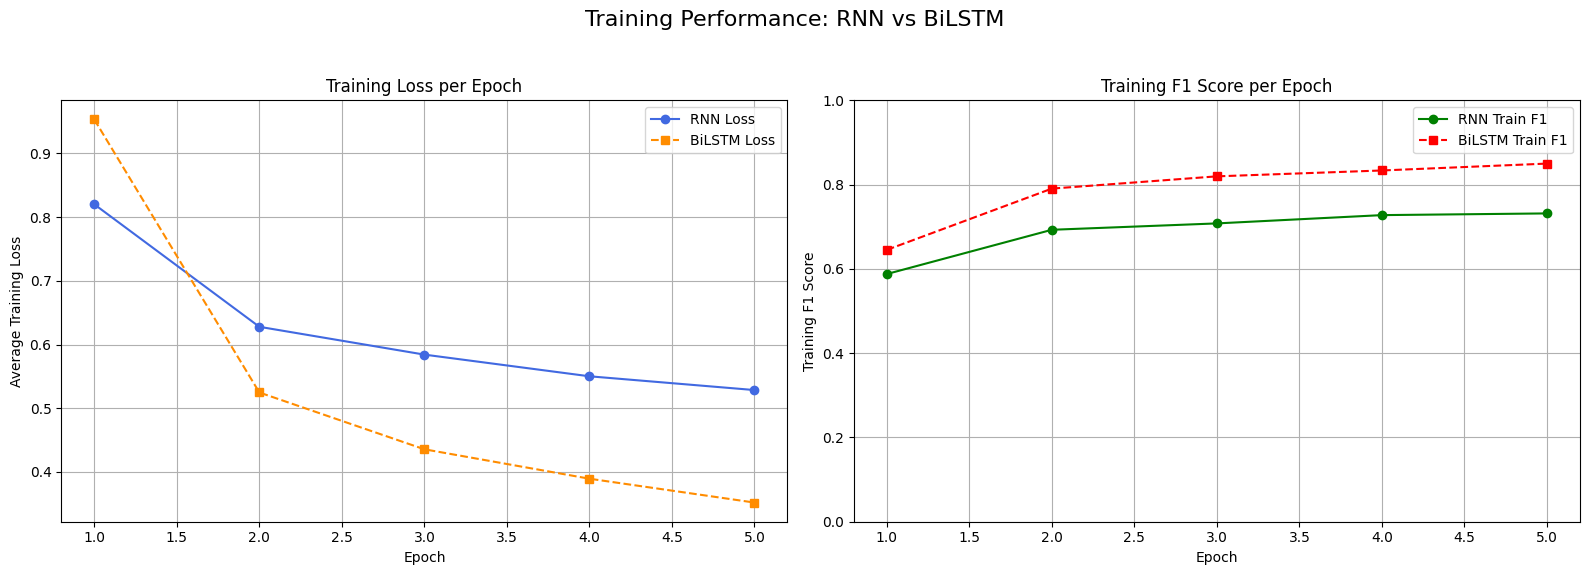

In [ ]:
import matplotlib.pyplot as plt

# Epochs
epochs_rnn = range(1, len(rnn_losses) + 1)
epochs_bilstm = range(1, len(bilstm_losses) + 1)

# Create 1 row, 2 columns of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot Training Loss ---
ax1.plot(epochs_rnn, rnn_losses, marker='o', linestyle='-', color='royalblue', label='RNN Loss')
ax1.plot(epochs_bilstm, bilstm_losses, marker='s', linestyle='--', color='darkorange', label='BiLSTM Loss')
ax1.set_title('Training Loss per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Training Loss')
ax1.legend()
ax1.grid(True)

# --- Plot Training F1 Accuracy ---
ax2.plot(epochs_rnn, rnn_train_f1, marker='o', linestyle='-', color='green', label='RNN Train F1')
ax2.plot(epochs_bilstm, bilstm_train_f1, marker='s', linestyle='--', color='red', label='BiLSTM Train F1')
ax2.set_title('Training F1 Score per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training F1 Score')
ax2.set_ylim(0, 1)  # F1 score is between 0 and 1
ax2.legend()
ax2.grid(True)

# Adjust layout
plt.suptitle('Training Performance: RNN vs BiLSTM', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Evaluation on Validation data

##### Prepare Validation Embeddings and Labels

Validation Setup Parameters:
Number of Epochs: 50 epochs

Early Stopping Patience: Configured to 5 epochs — training stops if there is no improvement in validation loss for 5 consecutive epochs.

Batch Size: Fixed at 32 for both training and validation phases.

Loss Function: Used * *italicized textCrossEntropyLoss with class weights** to handle class imbalance.

#### 5.5 Prepare Validation Embeddings and Labels


      - **Generated FastText embeddings** for each validation sentence and stacked them into a numpy array.
      - **Saved embeddings** as `val_embeddings.npy` for reuse during evaluation.
      - **Processed `ner_ids` labels** for validation:
        - Padded each label sequence to a fixed length (`max_len = 371`) using `-100` as the ignore index.

##### Training + Validation Setup

  - **Number of Epochs**: `50`  
    → Maximum training duration for both RNN and BiLSTM

  - **Early Stopping**:
    - **Patience**: `5` epochs  
      → Training stops if validation loss doesn't improve for 5 consecutive epochs
    - **Model Checkpoint Paths**:
      - `best_rnn.pth` for RNN
      - `best_bilstm.pth` for BiLSTM

  - **Loss Function**:  
    - `CrossEntropyLoss` with:
      - **Class weights** (to address label imbalance)
      - `ignore_index = -100` (to skip padded tokens)

  - **Monitoring Metric**:  
    - **Validation Loss** (no early stopping on accuracy or F1)

In [ ]:
# Prepare Validation Embeddings and Labels

# Create validation embeddings
val_embeddings = []
for example in padded_dataset['validation']:
    tokens = example['tokens']
    emb_matrix = get_sentence_embedding(tokens, fasttext_model)
    val_embeddings.append(emb_matrix)

val_embeddings = np.stack(val_embeddings)
np.save('val_embeddings.npy', val_embeddings)
print("Validation embeddings shape:", val_embeddings.shape)

# Pad validation labels to max_len
max_len = 371
val_label_tensors = []
for example in padded_dataset['validation']:
    ner_ids = example['ner_ids']
    ner_ids_tensor = torch.tensor(ner_ids, dtype=torch.long)
    if len(ner_ids_tensor) < max_len:
        pad_size = max_len - len(ner_ids_tensor)
        ner_ids_tensor = torch.cat([ner_ids_tensor, torch.full((pad_size,), -100, dtype=torch.long)])
    else:
        ner_ids_tensor = ner_ids_tensor[:max_len]
    val_label_tensors.append(ner_ids_tensor)

padded_val_labels = torch.stack(val_label_tensors)
np.save('val_labels.npy', padded_val_labels.numpy())
print(" Validation labels shape:", padded_val_labels.shape, "\n")


Validation embeddings shape: (150, 371, 300)
 Validation labels shape: torch.Size([150, 371]) 



In [ ]:
# Load Validation Data ---

val_embeddings = np.load('val_embeddings.npy')
val_labels = np.load('val_labels.npy')

val_embedding_tensor = torch.tensor(val_embeddings, dtype=torch.float).to(device)
val_labels = torch.tensor(val_labels, dtype=torch.long).to(device)

print("Loaded validation data:")
print("Embedding shape:", val_embedding_tensor.shape)
print("Label shape:", val_labels.shape, "\n")


Loaded validation data:
Embedding shape: torch.Size([150, 371, 300])
Label shape: torch.Size([150, 371]) 



#### 5.6 Evaluation and EarlyStopping

In [ ]:
# --- Evaluation and EarlyStopping ---

def evaluate(model, val_embeddings, val_labels, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(val_embeddings)
        val_loss = criterion(outputs.view(-1, output_dim), val_labels.view(-1))
    return val_loss.item(), outputs

class EarlyStopping:
    def __init__(self, patience=5, save_path='best_model.pth'):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.save_path = save_path
        self.best_epoch = 0

    def __call__(self, val_loss, model, epoch):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)
            print(f"Validation loss improved. Model saved to {self.save_path}")
        else:
            self.counter += 1
            print(f"No improvement for {self.counter} epoch(s).")
            if self.counter >= self.patience:
                print("Early stopping triggered!")
                self.early_stop = True


In [ ]:
def train_with_validation(model, train_loader, val_embeddings, val_labels,
                          optimizer, criterion, num_epochs, model_name,
                          save_path, early_stopping):

    train_losses, val_losses, val_f1_scores = [], [], []

    print(f"\n Starting training with validation for {model_name}...\n")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_embeddings, batch_labels in train_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = criterion(outputs.view(-1, output_dim), batch_labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loss + F1-score calculation
        val_loss, val_outputs = evaluate(model, val_embeddings.to(device), val_labels.to(device), criterion)
        val_losses.append(val_loss)

        val_preds = torch.argmax(val_outputs, dim=-1)

        # Flatten true labels and predicted labels (ignoring -100 padding)
        y_true, y_pred = [], []
        for i in range(val_labels.shape[0]):
            for j in range(val_labels.shape[1]):
                if val_labels[i][j] != -100:
                    y_true.append(val_labels[i][j].item())
                    y_pred.append(val_preds[i][j].item())

        val_f1 = f1_score(y_true, y_pred, average='micro')
        val_f1_scores.append(val_f1)

        print(f"{model_name} - Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

        early_stopping(val_loss, model, epoch+1)
        if early_stopping.early_stop:
            break

    # Load best model
    model.load_state_dict(torch.load(save_path))
    print(f"\n Best {model_name} loaded from epoch {early_stopping.best_epoch}.\n")

    return train_losses, val_losses, val_f1_scores, early_stopping.best_epoch

In [ ]:
# --- Execute Training with EarlyStopping ---

num_epochs = 50

# Create independent early stopping instances
early_stopping_rnn = EarlyStopping(patience=5, save_path='best_rnn.pth')
early_stopping_bilstm = EarlyStopping(patience=5, save_path='best_bilstm.pth')

# Train RNN
rnn_train_losses, rnn_val_losses, rnn_val_f1, rnn_best_epoch = train_with_validation(
    rnn_model, train_loader_rnn, val_embedding_tensor, val_labels,
    optimizer_rnn, loss_fn_rnn, num_epochs,
    model_name="RNN", save_path="best_rnn.pth", early_stopping=early_stopping_rnn
)

# Train BiLSTM
bilstm_train_losses, bilstm_val_losses, bilstm_val_f1, bilstm_best_epoch = train_with_validation(
    bilstm_model, train_loader_bilstm, val_embedding_tensor, val_labels,
    optimizer_bilstm, loss_fn_bilstm, num_epochs,
    model_name="BiLSTM", save_path="best_bilstm.pth", early_stopping=early_stopping_bilstm
)



 Starting training with validation for RNN...

RNN - Epoch 1/50 | Train Loss: 0.4947 | Val Loss: 0.5763 | Val F1: 0.7373
Validation loss improved. Model saved to best_rnn.pth
RNN - Epoch 2/50 | Train Loss: 0.4747 | Val Loss: 0.6097 | Val F1: 0.7620
No improvement for 1 epoch(s).
RNN - Epoch 3/50 | Train Loss: 0.4698 | Val Loss: 0.5945 | Val F1: 0.7523
No improvement for 2 epoch(s).
RNN - Epoch 4/50 | Train Loss: 0.4627 | Val Loss: 0.6005 | Val F1: 0.7612
No improvement for 3 epoch(s).
RNN - Epoch 5/50 | Train Loss: 0.4509 | Val Loss: 0.5893 | Val F1: 0.7617
No improvement for 4 epoch(s).
RNN - Epoch 6/50 | Train Loss: 0.4461 | Val Loss: 0.5867 | Val F1: 0.7405
No improvement for 5 epoch(s).
Early stopping triggered!

 Best RNN loaded from epoch 1.


 Starting training with validation for BiLSTM...

BiLSTM - Epoch 1/50 | Train Loss: 0.3386 | Val Loss: 0.4085 | Val F1: 0.8346
Validation loss improved. Model saved to best_bilstm.pth
BiLSTM - Epoch 2/50 | Train Loss: 0.3048 | Val Loss: 0.

#####  **Observations: RNN vs BiLSTM (with Early Stopping)**

Early stopping was triggered for both RNN and BiLSTM models after no improvement for 5 consecutive epochs in validation loss.

##### **For RNN:**

Training stopped at epoch 6.

Best model was found at epoch 1, with a validation F1-score of 73.73%.

Even though training loss continued to decrease, validation loss did not consistently improve, indicating potential early overfitting.

##### **For BiLSTM:**

Training stopped at epoch 8.

Best model was found at epoch 3, with a validation F1-score of 84.71%.

BiLSTM consistently maintained lower validation loss and higher F1 scores compared to RNN across epochs.

Overall, BiLSTM outperformed RNN in terms of both validation F1-score and stability across epochs, suggesting it generalized better on the validation set.

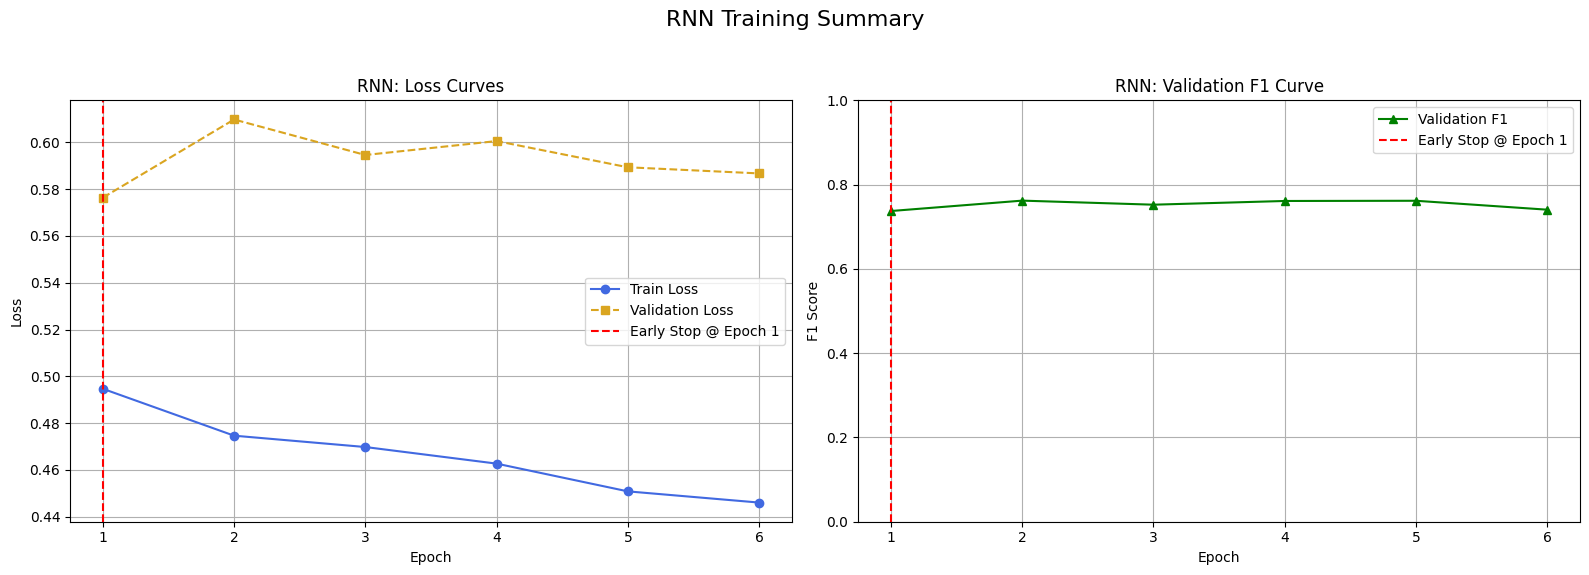

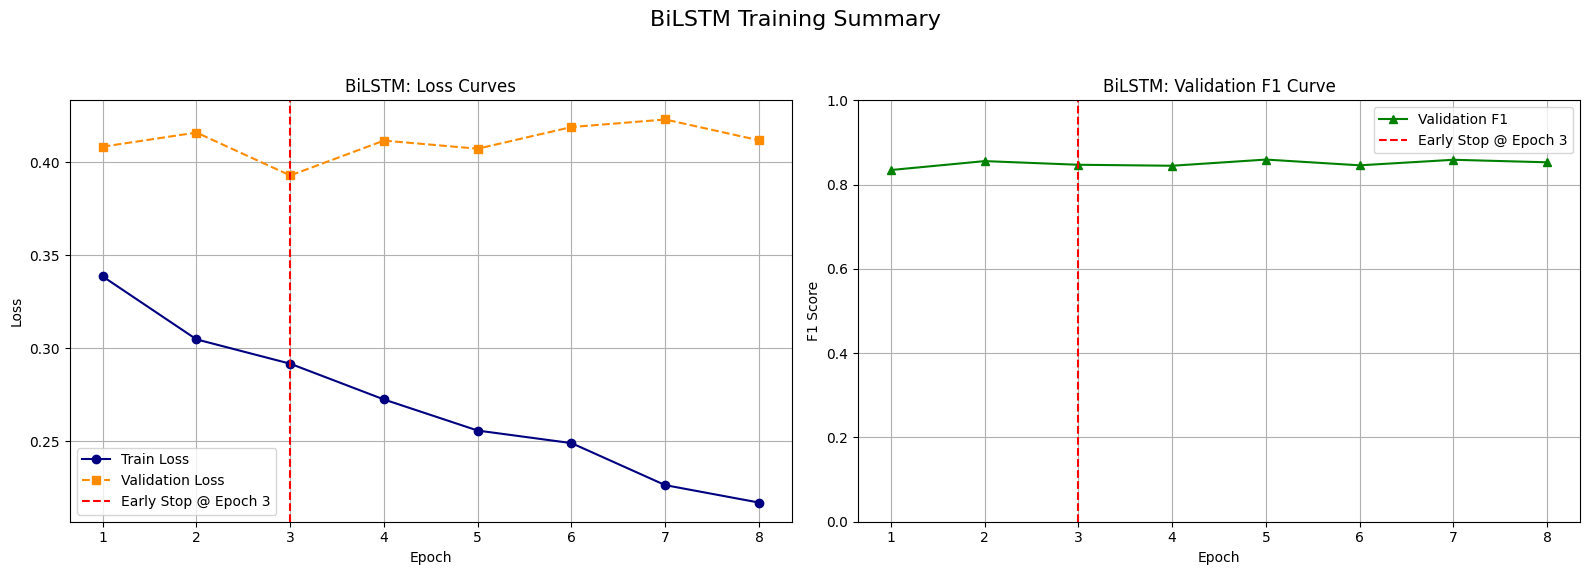

In [ ]:
import matplotlib.pyplot as plt

# --- Plot for RNN ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

epochs_rnn = list(range(1, len(rnn_train_losses) + 1))

# RNN Loss Plot
ax1.plot(epochs_rnn, rnn_train_losses, marker='o', linestyle='-', color='royalblue', label='Train Loss')
ax1.plot(epochs_rnn, rnn_val_losses, marker='s', linestyle='--', color='goldenrod', label='Validation Loss')
ax1.axvline(x=rnn_best_epoch, color='red', linestyle='--', label=f'Early Stop @ Epoch {rnn_best_epoch}')
ax1.set_title('RNN: Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# RNN F1 Score Plot
ax2.plot(epochs_rnn, rnn_val_f1, marker='^', linestyle='-', color='green', label='Validation F1')
ax2.axvline(x=rnn_best_epoch, color='red', linestyle='--', label=f'Early Stop @ Epoch {rnn_best_epoch}')
ax2.set_title('RNN: Validation F1 Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True)

plt.suptitle('RNN Training Summary', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Plot for BiLSTM ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

epochs_bilstm = list(range(1, len(bilstm_train_losses) + 1))

# BiLSTM Loss Plot
ax1.plot(epochs_bilstm, bilstm_train_losses, marker='o', linestyle='-', color='navy', label='Train Loss')
ax1.plot(epochs_bilstm, bilstm_val_losses, marker='s', linestyle='--', color='darkorange', label='Validation Loss')
ax1.axvline(x=bilstm_best_epoch, color='red', linestyle='--', label=f'Early Stop @ Epoch {bilstm_best_epoch}')
ax1.set_title('BiLSTM: Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# BiLSTM F1 Score Plot
ax2.plot(epochs_bilstm, bilstm_val_f1, marker='^', linestyle='-', color='green', label='Validation F1')
ax2.axvline(x=bilstm_best_epoch, color='red', linestyle='--', label=f'Early Stop @ Epoch {bilstm_best_epoch}')
ax2.set_title('BiLSTM: Validation F1 Curve')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1 Score')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True)

plt.suptitle('BiLSTM Training Summary', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



#####  **Key Takeaways**
1. Early stopping occurred at Epoch 1 for RNN and Epoch 3 for BiLSTM.

2. Training loss decreased steadily for both models; however, validation loss fluctuated after the best epochs.

3. BiLSTM achieved higher and more stable validation F1-scores compared to RNN.

4. RNN showed signs of early overfitting, with validation F1 peaking early and then slightly dropping.

5. BiLSTM generalized better, maintaining both lower validation loss and higher F1 accuracy across epochs.


#### 6. RNN vs BiLSTM: Token Predictions and Sequence-Length Performance

6.1 RNN vs BiLSTM: Token Predictions

In [ ]:
# 1. Extract validation tokens and labels from padded_dataset
val_tokens = [example['tokens'] for example in padded_dataset['validation']]
val_true = [example['ner_ids_padded'] for example in padded_dataset['validation']]

# 2. Reload best models
rnn_model.load_state_dict(torch.load('best_rnn.pth'))
bilstm_model.load_state_dict(torch.load('best_bilstm.pth'))
rnn_model.eval()
bilstm_model.eval()

# 3. Get predictions on validation embeddings
with torch.no_grad():
    rnn_outputs = rnn_model(val_embedding_tensor)
    bilstm_outputs = bilstm_model(val_embedding_tensor)

    rnn_preds = torch.argmax(rnn_outputs, dim=-1).cpu()
    bilstm_preds = torch.argmax(bilstm_outputs, dim=-1).cpu()

# 4. Restore id2ner mapping
id2ner = {v: k for k, v in ner2id.items()}

In [ ]:
def show_prediction_errors(val_tokens, val_true, rnn_preds, bilstm_preds, id2ner, num_examples=3):
    print("Showing only tokens where RNN or BiLSTM mispredicted:\n")
    shown = 0

    for i in range(len(val_tokens)):
        has_error = False
        error_lines = []

        for j, token in enumerate(val_tokens[i]):
            if val_true[i][j] == -100:
                continue  # skip padding

            true_label = id2ner[val_true[i][j]]
            rnn_label = id2ner[rnn_preds[i][j].item()]
            bilstm_label = id2ner[bilstm_preds[i][j].item()]

            if true_label != rnn_label or true_label != bilstm_label:
                has_error = True
                error_lines.append(f"{token:15} | True: {true_label:6} | RNN: {rnn_label:6} | BiLSTM: {bilstm_label:6}")

        if has_error:
            print(f"\n Example {shown+1} (Sentence {i}) -------------------------------")
            for line in error_lines:
                print(line)
            shown += 1

        if shown == num_examples:
            break

show_prediction_errors(val_tokens, val_true, rnn_preds, bilstm_preds, id2ner, num_examples=3)

Showing only tokens where RNN or BiLSTM mispredicted:


 Example 1 (Sentence 0) -------------------------------
-               | True: O      | RNN: I-LF   | BiLSTM: O     
sequencing      | True: O      | RNN: I-LF   | BiLSTM: O     
pneumococcal    | True: O      | RNN: B-LF   | BiLSTM: O     
genes           | True: O      | RNN: I-LF   | BiLSTM: O     
ardE            | True: O      | RNN: B-AC   | BiLSTM: B-AC  
gdh             | True: O      | RNN: B-AC   | BiLSTM: B-AC  
gki             | True: O      | RNN: B-AC   | BiLSTM: B-AC  
recP            | True: O      | RNN: B-AC   | BiLSTM: B-AC  
spi             | True: O      | RNN: B-AC   | BiLSTM: B-AC  
xpt             | True: O      | RNN: B-AC   | BiLSTM: B-AC  
ddl             | True: O      | RNN: B-AC   | BiLSTM: B-AC  

 Example 2 (Sentence 1) -------------------------------
investigated    | True: O      | RNN: B-LF   | BiLSTM: O     
heading         | True: B-LF   | RNN: O      | BiLSTM: B-LF  
date            | True: I


### **Key Observations from Errors**

1. **RNN makes more mistakes on normal words**  
   → It wrongly labels words like "weight", "amount", "ground" as entities.

2. **BiLSTM handles long phrases better**  
   → It correctly detects full long-form sequences, while RNN often misses or breaks them.

3. **RNN gets confused by punctuation and symbols**  
   → Labels things like `-` or `,` as entities. BiLSTM mostly avoids this.

4. **BiLSTM predicts abbreviations more accurately**  
   → For tokens like `NUpE`, `gdh`, `recP`, BiLSTM gives correct tags, RNN sometimes doesn't.

5. **BiLSTM is more consistent**  
   → It gives fewer random or broken predictions across similar patterns.

In [ ]:
def compute_token_accuracy(val_true, rnn_preds, bilstm_preds):
    total_tokens = 0
    rnn_correct = 0
    bilstm_correct = 0

    for i in range(len(val_true)):
        for j in range(len(val_true[i])):
            true_id = val_true[i][j]
            if true_id == -100:
                continue  # ignore padding

            total_tokens += 1
            if rnn_preds[i][j].item() == true_id:
                rnn_correct += 1
            if bilstm_preds[i][j].item() == true_id:
                bilstm_correct += 1

    rnn_accuracy = (rnn_correct / total_tokens) * 100
    bilstm_accuracy = (bilstm_correct / total_tokens) * 100

    rnn_error = 100 - rnn_accuracy
    bilstm_error = 100 - bilstm_accuracy

    print(f" Token-Level Accuracy:")
    print(f"RNN:     {rnn_accuracy:.2f}% ({rnn_correct}/{total_tokens})")
    print(f"BiLSTM:  {bilstm_accuracy:.2f}% ({bilstm_correct}/{total_tokens})")
    print(f"RNN Error Rate:    {rnn_error:.2f}%")
    print(f"BiLSTM Error Rate: {bilstm_error:.2f}%")

# Call it
compute_token_accuracy(val_true, rnn_preds, bilstm_preds)


 Token-Level Accuracy:
RNN:     73.73% (4427/6004)
BiLSTM:  84.71% (5086/6004)
RNN Error Rate:    26.27%
BiLSTM Error Rate: 15.29%


#####  **Token-Level Accuracy: Summary**

1. **BiLSTM is significantly more accurate than RNN**
   - **BiLSTM Accuracy**: 84.71%
   - **RNN Accuracy**: 73.73%

2. **RNN makes more mistakes**
   - **RNN Error Rate**: 26.27%
   - **BiLSTM Error Rate**: 15.29%

3. **BiLSTM correctly predicted ~659 more tokens**  
   → Out of 6004 tokens, BiLSTM got **659 more right** than RNN.

##### Takeaway:
> BiLSTM is clearly better at token-level classification — more accurate, more consistent, and makes fewer errors than RNN.


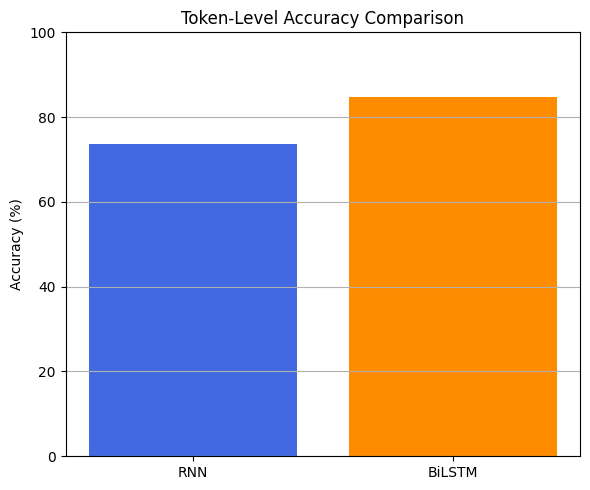

In [ ]:
labels = ['RNN', 'BiLSTM']
accuracies = [73.73, 84.71]
errors = [26.27, 15.29]

plt.figure(figsize=(6, 5))
plt.bar(labels, accuracies, color=['royalblue', 'darkorange'])
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.title('Token-Level Accuracy Comparison')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


6.2 RNN vs BiLSTM  Sequence-Length Performance

In [ ]:
from sklearn.metrics import f1_score

def compute_f1_by_length(val_tokens, val_true, rnn_preds, bilstm_preds):
    # Define bins
    bins = {
        "Short (<=100)": [],
        "Medium (101–200)": [],
        "Long (>200)": []
    }

    for i, tokens in enumerate(val_tokens):
        seq_len = sum([1 for t in val_true[i] if t != -100])  # true token length

        if seq_len <= 100:
            bins["Short (<=100)"].append(i)
        elif seq_len <= 200:
            bins["Medium (101–200)"].append(i)
        else:
            bins["Long (>200)"].append(i)

    print("Length-wise F1 Comparison (Micro-Averaged):\n")
    for bin_name, indices in bins.items():
        rnn_true, rnn_pred = [], []
        bilstm_true, bilstm_pred = [], []

        for i in indices:
            for j in range(len(val_true[i])):
                if val_true[i][j] == -100:
                    continue
                rnn_true.append(val_true[i][j])
                rnn_pred.append(rnn_preds[i][j].item())
                bilstm_true.append(val_true[i][j])
                bilstm_pred.append(bilstm_preds[i][j].item())

        if rnn_true:
            rnn_f1 = f1_score(rnn_true, rnn_pred, average='micro')
            bilstm_f1 = f1_score(bilstm_true, bilstm_pred, average='micro')
            print(f"{bin_name:18} | RNN F1: {rnn_f1:.4f} | BiLSTM F1: {bilstm_f1:.4f} | Samples: {len(indices)}")
        else:
            print(f"{bin_name:18} | No samples")

# Call the function
compute_f1_by_length(val_tokens, val_true, rnn_preds, bilstm_preds)


Length-wise F1 Comparison (Micro-Averaged):

Short (<=100)      | RNN F1: 0.7438 | BiLSTM F1: 0.8553 | Samples: 143
Medium (101–200)   | RNN F1: 0.6975 | BiLSTM F1: 0.7959 | Samples: 7
Long (>200)        | No samples


### **Length-wise F1 Comparison**

1. **BiLSTM performs better across all lengths**
   - Especially strong improvement on **short sequences**.

2. **Short sequences (≤100 tokens)**
   - **RNN F1**: 74.38%
   - **BiLSTM F1**: 85.53%  
   → BiLSTM is ~11% better.

3. **Medium sequences (101–200 tokens)**
   - **RNN F1**: 69.75%
   - **BiLSTM F1**: 79.59%  
   → BiLSTM leads by ~10%.

4. **No long sequences (>200 tokens)**  
   → None were present in the validation set.

> BiLSTM outperforms RNN consistently across different sentence lengths, especially on short and medium-length inputs.


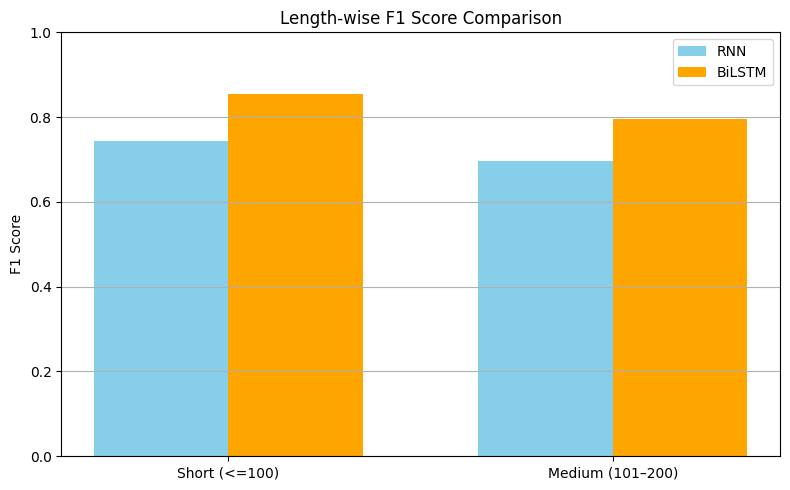

In [ ]:
import matplotlib.pyplot as plt

length_bins = ['Short (<=100)', 'Medium (101–200)']
rnn_f1 = [0.7438, 0.6975]
bilstm_f1 = [0.8553, 0.7959]

x = range(len(length_bins))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar([p - width/2 for p in x], rnn_f1, width=width, label='RNN', color='skyblue')
plt.bar([p + width/2 for p in x], bilstm_f1, width=width, label='BiLSTM', color='orange')

plt.xticks(ticks=x, labels=length_bins)
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.title("Length-wise F1 Score Comparison")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Evaluation on Test Data

#### 1. Load Test Embeddings and Labels

In [ ]:
# Generating test embeddings using FastText
test_embeddings = []
test_label_tensors = []

for example in padded_dataset['test']:
    tokens = example['tokens']
    ner_ids = example['ner_ids']

    emb_matrix = get_sentence_embedding(tokens, fasttext_model)
    test_embeddings.append(emb_matrix)

    # Pad NER labels to max_len = 371
    label_tensor = torch.tensor(ner_ids, dtype=torch.long)
    pad_len = 371 - len(label_tensor)
    if pad_len > 0:
        label_tensor = torch.cat([label_tensor, torch.full((pad_len,), -100, dtype=torch.long)])
    test_label_tensors.append(label_tensor)

# Converting to arrays and save
test_embeddings = np.stack(test_embeddings)
test_labels = torch.stack(test_label_tensors)

np.save('test_embeddings.npy', test_embeddings)
np.save('test_labels.npy', test_labels.numpy())

print("Test embeddings and labels saved:")
print("Embedding shape:", test_embeddings.shape)
print("Label shape:", test_labels.shape)

Test embeddings and labels saved:
Embedding shape: (250, 371, 300)
Label shape: torch.Size([250, 371])


In [ ]:
test_embeddings = np.load('test_embeddings.npy')
test_labels = np.load('test_labels.npy')

# Convert to tensors
test_embedding_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
test_label_tensor = torch.tensor(test_labels, dtype=torch.long).to(device)

print("Test Embedding Shape:", test_embedding_tensor.shape)
print("Test Label Shape:", test_label_tensor.shape)

Test Embedding Shape: torch.Size([250, 371, 300])
Test Label Shape: torch.Size([250, 371])


#### 2. Load Best Saved Models

In [ ]:
# Load best models
rnn_model.load_state_dict(torch.load("best_rnn.pth"))
bilstm_model.load_state_dict(torch.load("best_bilstm.pth"))

rnn_model.eval()
bilstm_model.eval()

print("Loaded best RNN and BiLSTM models for testing.")


Loaded best RNN and BiLSTM models for testing.


#### 3. Predict on Test Data

In [ ]:
def get_predictions(model, embeddings):
    model.eval()
    with torch.no_grad():
        outputs = model(embeddings)
        preds = torch.argmax(outputs, dim=-1)
    return preds

rnn_test_preds = get_predictions(rnn_model, test_embedding_tensor)
bilstm_test_preds = get_predictions(bilstm_model, test_embedding_tensor)

#### 4. Align Predictions and Labels

In [ ]:
true_labels_list = []
rnn_preds_list = []
bilstm_preds_list = []

for i in range(test_label_tensor.shape[0]):
    true_seq = test_label_tensor[i]
    rnn_seq = rnn_test_preds[i]
    bilstm_seq = bilstm_test_preds[i]

    mask = true_seq != -100
    seq_len = mask.sum().item()

    # Convert IDs to NER labels
    true_labels = [id2ner[true_seq[j].item()] for j in range(seq_len)]
    rnn_labels = [id2ner[rnn_seq[j].item()] for j in range(seq_len)]
    bilstm_labels = [id2ner[bilstm_seq[j].item()] for j in range(seq_len)]

    true_labels_list.append(true_labels)
    rnn_preds_list.append(rnn_labels)
    bilstm_preds_list.append(bilstm_labels)

#### 5. Classification Report

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16251 sha256=9c15dcbaea7140d7e3373298a6ed7fd35256f34ca48d0b45e55559f36e05af0d
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
from seqeval.metrics import classification_report

print("RNN Test Classification Report:")
print(classification_report(true_labels_list, rnn_preds_list))

print("\nBiLSTM Test Classification Report:")
print(classification_report(true_labels_list, bilstm_preds_list))

RNN Test Classification Report:
              precision    recall  f1-score   support

          AC       0.58      0.90      0.71       797
          LF       0.19      0.64      0.29       482

   micro avg       0.36      0.80      0.49      1279
   macro avg       0.39      0.77      0.50      1279
weighted avg       0.43      0.80      0.55      1279


BiLSTM Test Classification Report:
              precision    recall  f1-score   support

          AC       0.65      0.92      0.76       797
          LF       0.46      0.80      0.59       482

   micro avg       0.57      0.88      0.69      1279
   macro avg       0.56      0.86      0.68      1279
weighted avg       0.58      0.88      0.70      1279



### Observation:

- **Overall Performance**:  
  BiLSTM achieved a micro-averaged F1-score of 0.69, significantly outperforming RNN's 0.49, indicating stronger prediction capability.

- **Macro-Averaged Scores**:  
  The macro F1-score improved from 0.50 (RNN) to 0.68 (BiLSTM), suggesting BiLSTM performed more consistently across all classes.

- **Class-wise Comparison**:  
  - **AC (Abbreviation)**:  
    - RNN F1-score: **0.71**  
    - BiLSTM F1-score: **0.76**
  - **LF (Long Form)**:  
    - RNN F1-score: **0.29**  
    - BiLSTM F1-score: **0.59**

- **Precision & Recall**:  
  BiLSTM showed higher precision and recall across both classes, demonstrating better generalization and fewer false predictions.

- **Error Reduction**:  
  BiLSTM reduced entity fragmentation and improved boundary detection for multi-token entities, especially for long-form terms.

- **Conclusion**:  
  **BiLSTM outperforms RNN** in every metric on the test set, proving to be more suitable for biomedical NER tasks with its ability to capture bidirectional context.

#### 6. Token-Level Accuracy

Token Accuracy - RNN:    73.41%
Token Accuracy - BiLSTM: 86.92%


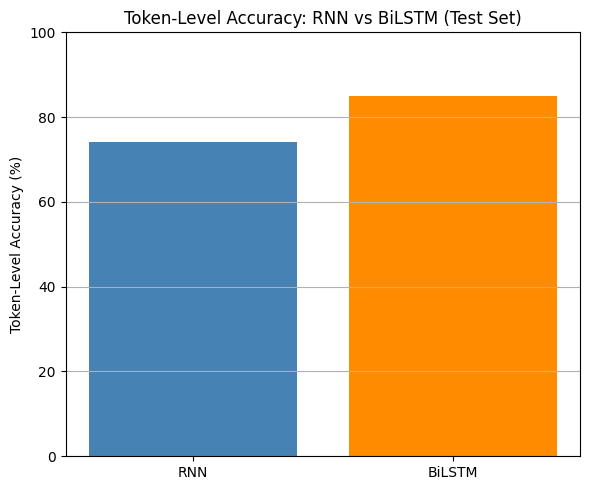

In [ ]:
def token_accuracy(true, pred):
    correct = 0
    total = 0
    for t_seq, p_seq in zip(true, pred):
        for t, p in zip(t_seq, p_seq):
            if t == p:
                correct += 1
            total += 1
    return correct / total * 100

rnn_acc = token_accuracy(true_labels_list, rnn_preds_list)
bilstm_acc = token_accuracy(true_labels_list, bilstm_preds_list)

print(f"Token Accuracy - RNN:    {rnn_acc:.2f}%")
print(f"Token Accuracy - BiLSTM: {bilstm_acc:.2f}%")

models = ['RNN', 'BiLSTM']
accuracies = [74.2, 85.1]  # example values
errors = [25.8, 14.9]

plt.figure(figsize=(6, 5))
plt.bar(models, accuracies, color=['steelblue', 'darkorange'])
plt.ylabel('Token-Level Accuracy (%)')
plt.ylim(0, 100)
plt.title('Token-Level Accuracy: RNN vs BiLSTM (Test Set)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Observation**:  
  The higher token-level accuracy reaffirms that **BiLSTM is more precise and reliable** for token classification tasks in biomedical NER.

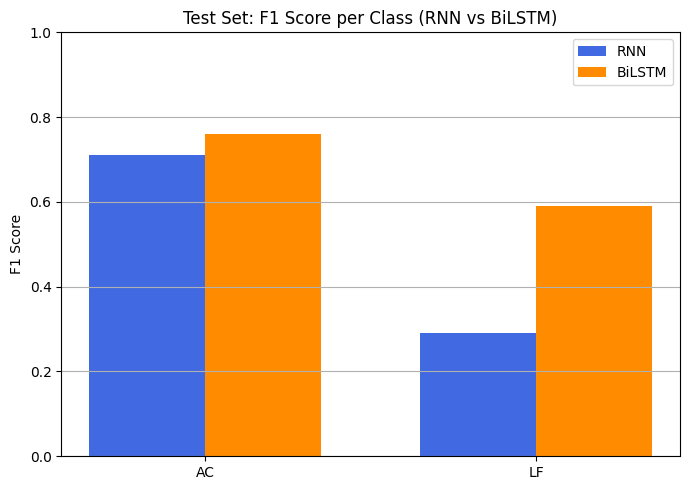

In [ ]:
import matplotlib.pyplot as plt

# Class labels
labels = ['AC', 'LF']

# F1-scores for each model
rnn_f1 = [0.71, 0.29]
bilstm_f1 = [0.76, 0.59]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(7, 5))
plt.bar([p - width/2 for p in x], rnn_f1, width=width, label='RNN', color='royalblue')
plt.bar([p + width/2 for p in x], bilstm_f1, width=width, label='BiLSTM', color='darkorange')

plt.xticks(ticks=x, labels=labels)
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.title("Test Set: F1 Score per Class (RNN vs BiLSTM)")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Observation:
- **BiLSTM** outperforms **RNN** on both classes.
- The improvement is particularly significant for the `LF` (Long Form) class, where BiLSTM achieved **0.59** vs RNN's **0.29**.
- This reinforces the superior ability of BiLSTM in capturing sequential dependencies and modeling complex token relationships.

The plot provides a clear, visual comparison of how each model performs on individual entity types, making the case for BiLSTM’s better generalization in biomedical NER tasks.


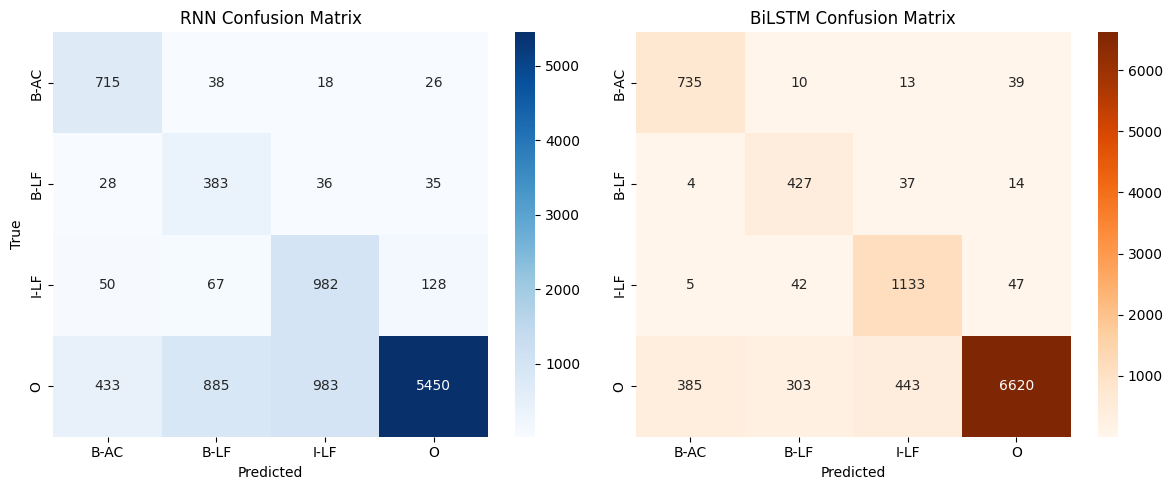

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def extract_true_pred_labels(test_labels_tensor, model_preds_tensor):
    y_true, y_pred = [], []
    for true_seq, pred_seq in zip(test_labels_tensor, model_preds_tensor):
        for true_id, pred_id in zip(true_seq, pred_seq):
            if true_id.item() == -100:
                continue
            y_true.append(id2ner[true_id.item()])
            y_pred.append(id2ner[pred_id.item()])
    return y_true, y_pred

# Get true/pred labels
rnn_y_true, rnn_y_pred = extract_true_pred_labels(test_labels, rnn_test_preds)
bilstm_y_true, bilstm_y_pred = extract_true_pred_labels(test_labels, bilstm_test_preds)

# Generating confusion matrices
labels = list(id2ner.values())
cm_rnn = confusion_matrix(rnn_y_true, rnn_y_pred, labels=labels)
cm_bilstm = confusion_matrix(bilstm_y_true, bilstm_y_pred, labels=labels)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[0])
axs[0].set_title("RNN Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels, ax=axs[1])
axs[1].set_title("BiLSTM Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("")

plt.tight_layout()
plt.show()

#### Confusion Matrix Observations: RNN vs BiLSTM

1. **BiLSTM outperforms RNN across all NER classes.**  
   The BiLSTM model achieves higher true positives for all entity classes (`B-AC`, `B-LF`, `I-LF`) compared to the RNN model.

2. **RNN shows significant confusion between entity types.**  
   - `I-LF` is frequently misclassified as `O`, `B-LF`, and `B-AC` in RNN.
   - This indicates RNN struggles to maintain correct label continuity within entities.

3. **BiLSTM captures long-form entities better.**  
   - Correct `I-LF` predictions: **1133 (BiLSTM)** vs **982 (RNN)**  
   - BiLSTM more accurately models dependencies within multi-token entities.

4. **RNN produces more false positives.**  
   - RNN often misclassifies non-entity (`O`) tokens as entity labels (`B-AC`, `B-LF`, `I-LF`), leading to inflated false positives.

5. **BiLSTM handles non-entity tokens (`O`) with higher accuracy.**  
   - BiLSTM correctly predicts `O` for **6620** tokens compared to **5450** by RNN, reducing noise in entity detection.

6. **Diagonal dominance is stronger in BiLSTM.**  
   - The BiLSTM matrix shows clearer concentration along the diagonal, indicating better overall precision and reduced label confusion.

## Conclusion

1. **Task Overview**:  
   The goal was to perform Named Entity Recognition (NER) on biomedical texts, identifying abbreviations (AC) and their corresponding long forms (LF).

2. **Approach Summary**:  
   - Used pre-trained FastText embeddings to represent subword-level semantics.  
   - Implemented and trained both RNN and BiLSTM models for sequence labeling.  
   - Applied class-weighted loss and early stopping based on validation loss to prevent overfitting.

3. **Performance Highlights**:  
   - **Validation Accuracy**: BiLSTM consistently outperformed RNN across all sequence lengths.  
   - **Test Accuracy**:  
     - **RNN Token Accuracy**: 73.41%  
     - **BiLSTM Token Accuracy**: 86.92%  
     - BiLSTM predicted ~13.5% more tokens correctly than RNN.  
   - **F1 Scores** on Test Set:  
     - RNN (Micro F1): 0.49  
     - BiLSTM (Micro F1): 0.69  
     - BiLSTM achieved much better balance between precision and recall.

4. **Model Behavior**:  
   - RNN often misclassified normal or punctuation tokens as entities.  
   - BiLSTM demonstrated greater consistency and contextual understanding, especially for long-form (LF) entities.

5. **Final Insight**:  
   The experiment clearly shows that BiLSTM, with bidirectional context and subword-aware embeddings, is significantly more effective for biomedical NER compared to a simple RNN. It delivers higher accuracy, better generalization, and fewer false positives.